# Setting up the Data

In [1]:
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as m
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

mpl.rcParams['figure.dpi']= 150

In [2]:
df = pd.read_csv('AASG_Thermed_AllTempsThicksConds.csv',low_memory=False)
# Drop 3 sigma outliers for HeatFlow
def outlierDrop(df,df_toCheck,std_cut_off):
    init_len = df.shape[0]
    for i in df_toCheck:
        mean = df[i].mean()
        std = df[i].std()
        cut_off = std * std_cut_off
        lower, upper =mean - cut_off, mean + cut_off
        df = df[(df[i] < upper) & (df[i] > lower)]
    print("numbere of outliers removed: ", init_len - df.shape[0])
    return df
df = outlierDrop(df,['HeatFlow'],3)
df = df[df['HeatFlow']>0]
df.reset_index(inplace=True, drop=True)

# Form X and Y
X = np.transpose(np.array([df.LatDegree,
                                df.LongDegree,
                                df.MeasureDepth_m,
                                df.SurfTemp]))
Y = df.CorrBHT.values
# Add Geological Layer information to X
layers = df.iloc[:,52:101].values
conds = df.iloc[:,101:150].values
mult = np.multiply(layers,conds)
np.nan_to_num(mult, 0)
X = np.concatenate((X, mult),axis=1)

numbere of outliers removed:  67


# Hyperparameter Tuning - Ridge Regression

In [3]:
scaler = StandardScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)

In [23]:
def RidgeLoop(a):
    error = []
    for i in range(0,1):
        X_train, X_test, y_train, y_test = train_test_split(scaled_X, Y, test_size=0.10, random_state=10)
        rid = Ridge(alpha=a)
        rid.fit(X_train, y_train)
        y_pred = rid.predict(X_test)
        error.append(m.mean_absolute_error(y_test, y_pred))
    return np.mean(error)

In [42]:
np.logspace(-3, 0, 30)

array([0.001     , 0.00126896, 0.00161026, 0.00204336, 0.00259294,
       0.00329034, 0.00417532, 0.00529832, 0.00672336, 0.00853168,
       0.01082637, 0.01373824, 0.01743329, 0.02212216, 0.02807216,
       0.03562248, 0.04520354, 0.05736153, 0.07278954, 0.09236709,
       0.11721023, 0.14873521, 0.18873918, 0.23950266, 0.30391954,
       0.38566204, 0.48939009, 0.62101694, 0.78804628, 1.        ])

In [40]:
res = []
param = []
for i in np.logspace(-3, 0, 30):
    param.append(i)
    res.append(RidgeLoop(i))

Text(0.5, 1.0, 'Error Rate for Regularization Weight')

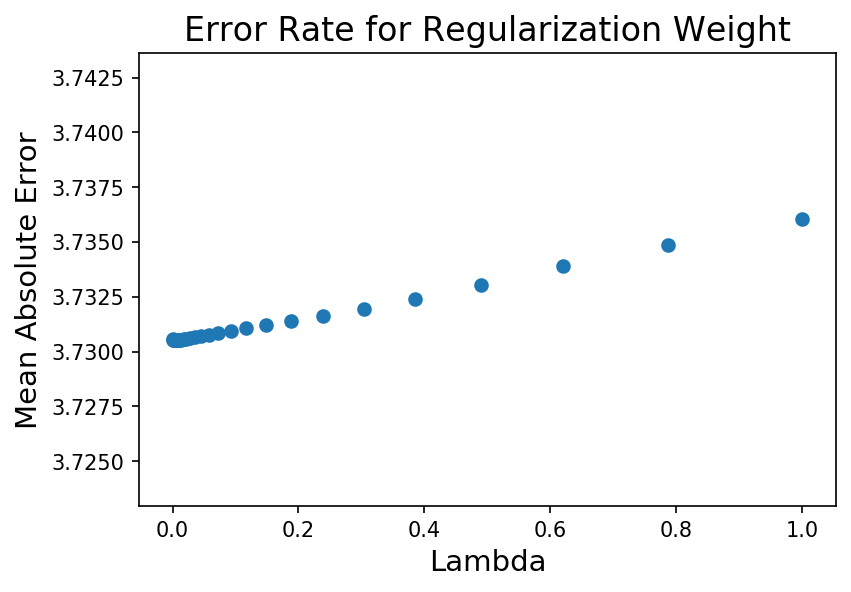

In [41]:
plt.scatter(param, res)
plt.xlabel('Lambda', fontsize=14)
plt.ylabel('Mean Absolute Error', fontsize=14)
plt.title('Error Rate for Regularization Weight', fontsize=16)

# Hyperparameter Tuning - Random Forest

In [43]:
def RfLoop(depth):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=int(100*np.random.random()))
    model = RandomForestRegressor(max_depth=depth, n_estimators=50)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return m.mean_absolute_error(y_test, y_pred)

In [44]:
res = []
param = []
for i in np.linspace(2,15,14):
    param.append(i)
    res.append(RfLoop(i))

Text(0.5, 1.0, 'Error Rate for Depth')

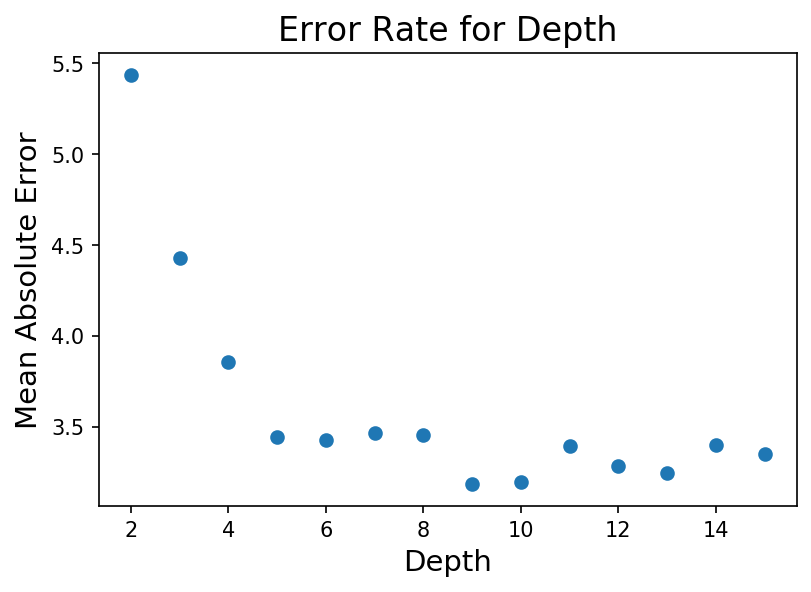

In [45]:
plt.scatter(param, res)
plt.xlabel('Depth', fontsize=14)
plt.ylabel('Mean Absolute Error', fontsize=14)
plt.title('Error Rate for Depth', fontsize=16)

# Hyperparameter Tuning - XGBoost

In [ ]:
# 10 bootstrapped cross-validation
def xgb_10cv(a,l,g):

    mae = []
    mse = []
    std = []
    for q in range(0,10):
        t = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=int(100*np.random.random()))
        gbm = xgb.XGBRegressor(learning_rate=0.01,
                               objective='reg:squarederror', 
                               n_estimators=2000, 
                               reg_alpha = a,
                               reg_lambda = l,
                               max_depth=10,
                               gamma=g)
        gbm.fit(X_train, y_train)
        y_pred = gbm.predict(X_test)
        # very rarely nan can be produced (it's a bug), so we need to customize
        mae.append(np.nanmean(abs(y_test-y_pred)))
        mse.append(np.nanmean(abs(y_test-y_pred)**2))
        std.append(np.nanstd(abs(y_test-y_pred)))
        elapsed = time.time() - t
        print(elapsed, "seconds for model#",q)
    return np.mean(mae), np.mean(mse), np.mean(std)

In [ ]:
result = []
# This takes about 4 hours on 10 GTX 1060. That means 40 hours on a single one.
for i in [0.1, 1, 10, 100]:
    for j in [0, 0.1, 1, 10, 100]:
        for k in [0, 0.1, 1, 10, 100]:
            mae, mse, std = xgb_10cv(i,j,k)
            print(mae, mse, std)
            result.append([i,j,k,mae,mse,std])

In [3]:
# Saved from bootsrapped run. (Every row is average over 10 bootstrapped runs)
# Format is [alpha, lambda, gamma, mae, rmse, std]
result = np.array([[0, 0, 0, 3.3089564000717595, 26.137197570389965, 3.894784155140831],
                   [0, 0, 0.1, 3.3095381605750602, 26.136905463488585, 3.890483780836764],
                   [0, 0, 1, 3.3343784325175334, 27.508396143497663, 4.045828125913606],
                   [0, 0, 10, 3.290089664172892, 25.651018644160786, 3.8484752867572327],
                   [0, 0, 100, 3.255151559353677, 25.118611537875104, 3.8083006557575003],
                   [0, 0.1, 0, 3.297937559123189, 26.291732672469813, 3.9244215209886093],
                   [0, 0.1, 0.1, 3.307918726372892, 26.19894156812915, 3.901261389806888],
                   [0, 0.1, 1, 3.2745236132771858, 25.39674255085645, 3.827410582169379], 
                   [0, 0.1, 10, 3.2778525258154323, 25.521679066262564, 3.8422308594152015],
                   [0, 0.1, 100, 3.2731089556788704, 25.384451576995595, 3.82775143815916],
                   [0, 1, 0, 3.2692829618901955, 25.47499006165487, 3.840979453574561],
                   [0, 1, 0.1, 3.2462094914785014, 24.803834527269007, 3.769496791229158],
                   [0, 1, 1, 3.2466418063276903, 25.029848062114606, 3.8028985255487826],
                   [0, 1, 10, 3.28105907983295, 25.632548060792708, 3.8543095967709995],
                   [0, 1, 100, 3.2510566774714653, 25.06378053967094, 3.802399647361514],
                   [0, 10, 0, 3.1930654274190022, 24.30647122792652, 3.750752140253469],
                   [0, 10, 0.1, 3.240183929504321, 24.724305051911198, 3.766501124532059],
                   [0, 10, 1, 3.1920557552199096, 24.45658022172322, 3.770300025703274],
                   [0, 10, 10, 3.2375410149045485, 25.30546742340012, 3.8477162108342924],
                   [0, 10, 100, 3.2662153212595797, 25.157184209794856, 3.802244523973793],
                   [0, 100, 0, 3.214720579137179, 24.54368800284053, 3.7661342407998064],
                   [0, 100, 0.1, 3.2274407023561493, 24.44979908834264, 3.7438891277892536],
                   [0, 100, 1, 3.2132110002162095, 24.149642071608714, 3.714291378127524],
                   [0, 100, 10, 3.241489102437017, 24.07265984067189, 3.678117349652119],
                   [0, 100, 100, 3.2982586404130765, 24.792195468220477, 3.727167717268325],
                   [0.1, 0, 0, 3.379930258418747, 27.73576995918081, 4.037611267980804],
                   [0.1, 0, 0.1, 3.316340452909871, 26.578966676539444, 3.9432531433504465],
                   [0.1, 0, 1, 3.2994142902910975, 26.29189435467241, 3.9147019868762314],
                   [0.1, 0, 10, 3.316570653110027, 26.23806509511537, 3.89990360465103],
                   [0.1, 0, 100, 3.2951632042137335, 26.202350383818604, 3.9108872316650816],
                   [0.1, 0.1, 0, 3.2342862317692562, 24.82739800149849, 3.78463391806186],
                   [0.1, 0.1, 0.1, 3.268731477424308, 25.412602776148386, 3.834348282516472],
                   [0.1, 0.1, 1, 3.31002331303742, 26.794166897986116, 3.9723362569667335],
                   [0.1, 0.1, 10, 3.323386637496024, 26.827247694976734, 3.9666732718753837],
                   [0.1, 0.1, 100, 3.367434036533827, 27.19887822817792, 3.9798017390932783],
                   [0.1, 1, 0, 3.261864299785254, 25.69716712697692, 3.8776180184989024],
                   [0.1, 1, 0.1, 3.2919899535209156, 26.866619328403015, 3.994513963605109],
                   [0.1, 1, 1, 3.264392978832624, 25.756053074730552, 3.8803305677478037],
                   [0.1, 1, 10, 3.2876373375271477, 25.654999189291924, 3.8517523501753255],
                   [0.1, 1, 100, 3.251039578749539, 24.260087206864288, 3.694613563371779], 
                   [0.1, 10, 0, 3.224846176114209, 24.43730360717155, 3.743350490122297], 
                   [0.1, 10, 0.1, 3.2285127532330895, 24.990913691216054, 3.807813933608474],
                   [0.1, 10, 1, 3.256402087991636, 25.500238296030385, 3.8555654348188364], 
                   [0.1, 10, 10, 3.169214798782755, 24.23950725843786, 3.7641540970873932], 
                   [0.1, 10, 100, 3.246331632652006, 24.54286429925927, 3.738523765516458], 
                   [0.1, 100, 0, 3.2598079857999416, 24.541939473607368, 3.7266554977449813], 
                   [0.1, 100, 0.1, 3.2314806342265796, 24.983593444424038, 3.807951547696258],
                   [0.1, 100, 1, 3.207297591599656, 24.45540380833822, 3.760119105139554], 
                   [0.1, 100, 10, 3.1742135438212467, 23.40205603285616, 3.6482239570160155],
                   [0.1, 100, 100, 3.2872500197052665, 25.01145961959434, 3.766729575673767],
                   [1, 0, 0, 3.323668456045467, 26.99639426794717, 3.989714041209942], 
                   [1, 0, 0.1, 3.3083378342149805, 26.199252366400408, 3.9023755684390515], 
                   [1, 0, 1, 3.320391114922438, 26.246051785385152, 3.8986652156811124], 
                   [1, 0, 10, 3.264255825080126, 25.528516455820277, 3.8525528624457124], 
                   [1, 0, 100, 3.2488541492926166, 25.04406468677051, 3.8030747660583266], 
                   [1, 0.1, 0, 3.2587886367890215, 26.03653771949679, 3.917201106408539], 
                   [1, 0.1, 0.1, 3.293946723481703, 26.472812485212565, 3.948248537120019], 
                   [1, 0.1, 1, 3.3357149221258644, 27.436525555255297, 4.034130308094365], 
                   [1, 0.1, 10, 3.3047860672532794, 26.239782669118426, 3.9089734610109277], 
                   [1, 0.1, 100, 3.254554021235875, 25.119872787119156, 3.8087047997495134], 
                   [1, 1, 0, 3.179933456993565, 24.190212490667477, 3.746954978290681], 
                   [1, 1, 0.1, 3.226712507080743, 24.90993475094039, 3.8040436687928354], 
                   [1, 1, 1, 3.2311247732240984, 25.02078943878542, 3.8127613356682892], 
                   [1, 1, 10, 3.299338528028585, 26.321976682032698, 3.923903123150427], 
                   [1, 1, 100, 3.2447393589564726, 25.17416314333836, 3.8235284930210867], 
                   [1, 10, 0, 3.2628336107766662, 24.64686964404958, 3.739068893985441], 
                   [1, 10, 0.1, 3.1499312913132638, 23.067540958816544, 3.6233081782484566], 
                   [1, 10, 1, 3.1941424419578572, 23.676312024162293, 3.668250528635427], 
                   [1, 10, 10, 3.2711081866137333, 24.885513902586283, 3.7603003453110455], 
                   [1, 10, 100, 3.252019756367016, 24.175821889831475, 3.6847606867612526], 
                   [1, 100, 0, 3.1988342049254634, 23.508019278001868, 3.638383244093089], 
                   [1, 100, 0.1, 3.218306968049796, 24.250680152095338, 3.7215788996909227], 
                   [1, 100, 1, 3.2012124407327205, 23.971638645969144, 3.6994544648469647], 
                   [1, 100, 10, 3.229703875577248, 24.86211283494338, 3.7950099811478823], 
                   [1, 100, 100, 3.256698088749846, 24.1548331859012, 3.678985539529846],
                   [10, 0, 0, 3.2184828426627057, 24.87380726818737, 3.804316724568732], 
                   [10, 0, 0.1, 3.242534109173352, 25.03756858276069, 3.8050072621692856],
                   [10, 0, 1, 3.2832941340723862, 26.22677425637908, 3.9275294427938037], 
                   [10, 0, 10, 3.255643199822721, 25.677559297487402, 3.8779989740217617], 
                   [10, 0, 100, 3.2288218218786375, 24.01950175552563, 3.6844459024677043], 
                   [10, 0.1, 0, 3.2746589146020626, 25.983597481469523, 3.9015963996532], 
                   [10, 0.1, 0.1, 3.286103144930639, 26.13660525199033, 3.9133492726671735], 
                   [10, 0.1, 1, 3.237592649699066, 25.743639920839296, 3.900828794242525], 
                   [10, 0.1, 10, 3.258801168692083, 25.42255699603124, 3.8425356870748586], 
                   [10, 0.1, 100, 3.2643803152347592, 25.278892698610104, 3.820528243793672],
                   [10, 1, 0, 3.2143959684395034, 24.802785002407518, 3.7992026653396493], 
                   [10, 1, 0.1, 3.2591638233600455, 25.405486587957206, 3.841183486201701], 
                   [10, 1, 1, 3.261734020776264, 25.760717600644462, 3.8823917037325257], 
                   [10, 1, 10, 3.241561740034718, 25.08146004167265, 3.8143682619514307], 
                   [10, 1, 100, 3.254574506828918, 24.90370864894295, 3.7771418625961592], 
                   [10, 10, 0, 3.200263521490952, 24.854279464922215, 3.8173040102042], 
                   [10, 10, 0.1, 3.2246321832227367, 24.768179364461275, 3.7851238144450265], 
                   [10, 10, 1, 3.215855224033014, 24.324412593951656, 3.7361654279988854], 
                   [10, 10, 10, 3.202362570879476, 24.0930219694112, 3.712951398715763], 
                   [10, 10, 100, 3.2817997051155885, 24.909088183331402, 3.7575107122947755],
                   [10, 100, 0, 3.2197718163478752, 24.35382015278875, 3.7368181478202716], 
                   [10, 100, 0.1, 3.1925986596336084, 23.80013241188484, 3.6847582367000946], 
                   [10, 100, 1, 3.2202612669993256, 24.1858825125631, 3.7124051510200102],
                   [10, 100, 10, 3.2718523851648653, 25.818009177032053, 3.8845111492252338],
                   [10, 100, 100, 3.300089414237255, 25.33301131913834, 3.7974719579994263],
                   [100, 0, 0, 3.2091462534722064, 23.95868379629752, 3.6931336245607382], 
                   [100, 0, 0.1, 3.236099470433196, 24.084879382771454, 3.684686016982725], 
                   [100, 0, 1, 3.232563201078549, 25.042472081142726, 3.8160800517110993], 
                   [100, 0, 10, 3.2145574448628893, 24.554342727520382, 3.76550916233836], 
                   [100, 0, 100, 3.2910511436185304, 25.00406726491989, 3.7595212908286966], 
                   [100, 0.1, 0, 3.218301234443424, 24.855488058332092, 3.8014705508662177], 
                   [100, 0.1, 0.1, 3.234942759394241, 24.446651741690555, 3.737323578231787], 
                   [100, 0.1, 1, 3.2851177820367328, 25.943591418797183, 3.888939400732167], 
                   [100, 0.1, 10, 3.2377403781586063, 24.69986002568617, 3.763508928952684], 
                   [100, 0.1, 100, 3.309265789796769, 25.12011570994101, 3.7602978647486047], 
                   [100, 1, 0, 3.211753169113787, 23.986473494910392, 3.6940382368564366], 
                   [100, 1, 0.1, 3.1984240916476123, 24.218119016493965, 3.7360438849731112], 
                   [100, 1, 1, 3.2208639926439337, 24.23663525457628, 3.7204066583297504], 
                   [100, 1, 10, 3.220932181955481, 24.253632659707492, 3.7223188092115933], 
                   [100, 1, 100, 3.2980105615537334, 25.441314751620126, 3.8139375937440567], 
                   [100, 10, 0, 3.2237309982706206, 24.8238334538145, 3.7952029702852785], 
                   [100, 10, 0.1, 3.234866856593024, 24.896644052768178, 3.794407694168529], 
                   [100, 10, 1, 3.1937512278854703, 24.105518556928544, 3.7238895635197466], 
                   [100, 10, 10, 3.2111334591013465, 24.120020442606965, 3.7125038490214273], 
                   [100, 10, 100, 3.2571849312936996, 24.916072319393763, 3.7753645457768044], 
                   [100, 100, 0, 3.233308665457072, 24.690190880066385, 3.770379890820437], 
                   [100, 100, 0.1, 3.24442421831034, 25.240351979048988, 3.833864071215481], 
                   [100, 100, 1, 3.2083721888230436, 24.15842392196601, 3.712915663204697], 
                   [100, 100, 10, 3.2211875411802575, 24.583110710113885, 3.7656166844043013], 
                   [100, 100, 100, 3.2948644391039097, 25.623804159234975, 3.839833874978429]])

In [4]:
# find minimum error
print(result[result[:,4].argmin()]) # minimum rmse - stable results
print(result[result[:,3].argmin()]) # minimum mae - if large error is just as bad as small error, this is better

[ 1.         10.          0.1         3.14993129 23.06754096  3.62330818]
[ 1.         10.          0.1         3.14993129 23.06754096  3.62330818]


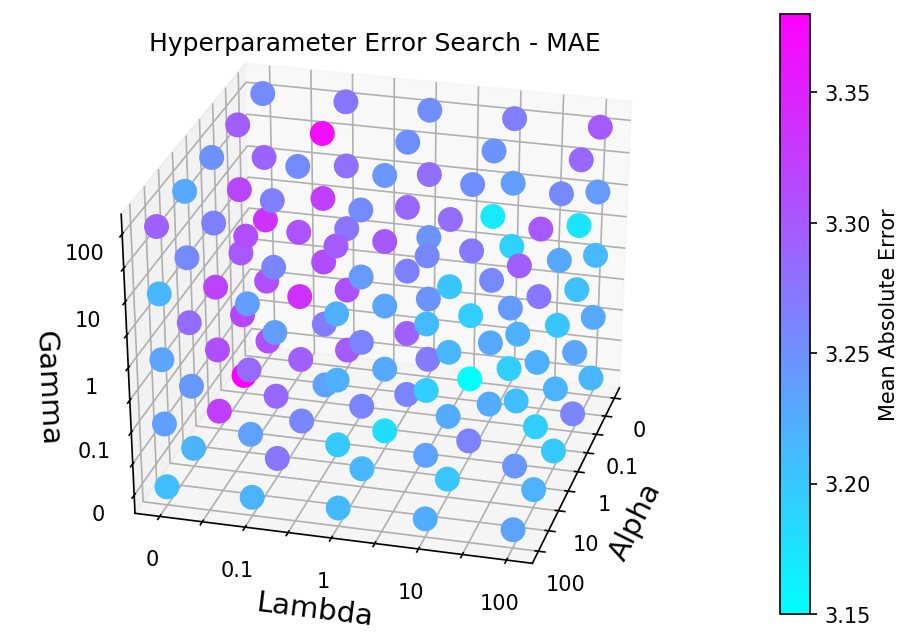

In [5]:
from mpl_toolkits.mplot3d import axes3d, Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)
ax.view_init(30, 15)

import pandas as pd
df_temp = pd.DataFrame({'x':result[:,0],'y':result[:,1],'z':result[:,2]})
x_ = df_temp.x.astype('category').cat.codes
y_ = df_temp.y.astype('category').cat.codes
z_ = df_temp.z.astype('category').cat.codes

p = ax.scatter3D(x_,y_,z_,c=result[:,3], cmap='cool', s=120, alpha=1);
ax.set_xlabel('Alpha', fontsize=14, rotation = 0)
ax.set_ylabel('Lambda', fontsize=14, rotation = 0)
ax.set_zlabel('Gamma', fontsize=14, rotation = 0)
plt.title('Hyperparameter Error Search - MAE')

# from https://stackoverflow.com/questions/11244514/modify-tick-label-text
fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['',0,'',0.1,'',1,'',10,'',100]
ax.set_xticklabels(labels)

labels = [item.get_text() for item in ax.get_yticklabels()]
labels = ['',0,'',0.1,'',1,'',10,'',100]
ax.set_yticklabels(labels)

labels = [item.get_text() for item in ax.get_zticklabels()]
labels = ['',0,'',0.1,'',1,'',10,'',100]
ax.set_zticklabels(labels)


cbar=plt.colorbar(p)
cbar.set_label("Mean Absolute Error")
# Visualization seem to match the minimum error we got.

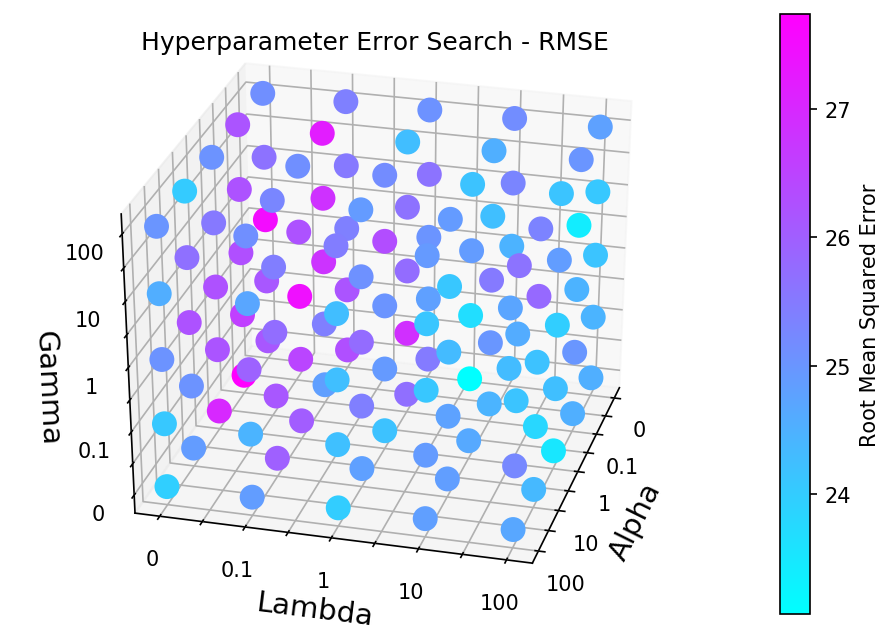

In [6]:
from mpl_toolkits.mplot3d import axes3d, Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.view_init(30, 15)

import pandas as pd
df_temp = pd.DataFrame({'x':result[:,0],'y':result[:,1],'z':result[:,2]})
x_ = df_temp.x.astype('category').cat.codes
y_ = df_temp.y.astype('category').cat.codes
z_ = df_temp.z.astype('category').cat.codes

p = ax.scatter3D(x_,y_,z_,c=result[:,4], cmap='cool', s=120, alpha=1);
ax.set_xlabel('Alpha', fontsize=14, rotation = 0)
ax.set_ylabel('Lambda', fontsize=14, rotation = 0)
ax.set_zlabel('Gamma', fontsize=14, rotation = 0)
plt.title('Hyperparameter Error Search - RMSE')

# from https://stackoverflow.com/questions/11244514/modify-tick-label-text
fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['',0,'',0.1,'',1,'',10,'',100]
ax.set_xticklabels(labels)

labels = [item.get_text() for item in ax.get_yticklabels()]
labels = ['',0,'',0.1,'',1,'',10,'',100]
ax.set_yticklabels(labels)

labels = [item.get_text() for item in ax.get_zticklabels()]
labels = ['',0,'',0.1,'',1,'',10,'',100]
ax.set_zticklabels(labels)


cbar=plt.colorbar(p)
cbar.set_label("Root Mean Squared Error")

# DNN Tuning is Abbreviated

# CV for Ridge for Old Data from Excel

In [4]:
def RidgeRandom():
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, Y, test_size=0.10, random_state=int(100*np.random.random()))
    rid = Ridge(alpha=0.01)
    rid.fit(X_train, y_train)
    y_pred = rid.predict(X_test)
    std = (np.nanstd(abs(y_test-y_pred)))
    return m.mean_absolute_error(y_test, y_pred), m.mean_squared_error(y_test, y_pred), std

In [5]:
mae_ridge = []
mse_ridge = []
std_ridge = []

for i in range(0, 10):
    mae, mse, std = RidgeRandom()
    mae_ridge.append(mae)
    mse_ridge.append(mse)
    std_ridge.append(std)
print(np.mean(mae_ridge), np.sqrt(np.mean(mse_ridge)), np.mean(std_ridge)) 

3.5269132395110234 5.241880255653555 3.874172244883126


# CV for RF for Old Data from Excel

In [6]:
def RfRandom():
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=int(100*np.random.random()))
    model = RandomForestRegressor(max_depth=10, n_estimators=50)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    std = (np.nanstd(abs(y_test-y_pred)))
    return m.mean_absolute_error(y_test, y_pred), m.mean_squared_error(y_test, y_pred), std

In [7]:
mae_rf = []
mse_rf = []
std_rf = []

for i in range(0, 10):
    mae, mse, std = RfRandom()
    mae_rf.append(mae)
    mse_rf.append(mse)
    std_rf.append(std)
print(np.mean(mae_rf), np.sqrt(np.mean(mse_rf)), np.mean(std_rf)) 

3.266397401426178 5.01215798274322 3.798444453559096


# CV for XGBoost for Old Data from Excel

In [8]:
import xgboost as xgb
mae_xgb = []
mse_xgb = []
std_xgb = []
for i in range(0, 10):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=(int(100*np.random.random())))
    gbm = xgb.XGBRegressor(learning_rate=0.01,  
                           objective='reg:squarederror', 
                           n_estimators=2000, 
                           reg_alpha=1,
                           reg_lambda=10,
                           max_depth=10, 
                           gamma=0.1)
    gbm.fit(X_train, y_train)
    y_pred = gbm.predict(X_test)
    mae_xgb.append(m.mean_absolute_error(y_test, y_pred))
    mse_xgb.append(m.mean_squared_error(y_test, y_pred))
    std_xgb.append(np.nanstd(abs(y_test-y_pred)))

In [9]:
print(np.mean(mae_xgb), np.mean(mse_xgb), np.mean(std_xgb))

3.2339625707594015 24.656517968730302 3.7619742449265017


# CV for DNN for Old Data from Excel

In [5]:
# evaluate model
from sklearn.model_selection import train_test_split
import sklearn.metrics as m
mae3 = []
mse3 = []
std3 = []
for i in range(0, 10):
    
    def baseline_model():
        # create model
        # Sequential model is for just building up each layer
        model = Sequential()
        # Kernel initializer sets up the distribution for the random parameters
        model.add(Dense(50, 
                        kernel_initializer='normal', activation='relu'))
        model.add(Dense(50, 
                        kernel_initializer='normal', activation='relu'))
        model.add(Dense(1, kernel_initializer='normal', activation='relu'))
        # Compile model
        model.compile(loss='mean_squared_error', optimizer='adam')
        return model


    model = KerasRegressor(build_fn=baseline_model, epochs=200, batch_size=50, verbose=0)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, Y, test_size=0.10, random_state=(int(100*np.random.random())))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae3.append(m.mean_absolute_error(y_test, y_pred))
    mse3.append(m.mean_squared_error(y_test, y_pred))
    std3.append(np.nanstd(abs(y_test-y_pred)))
print(np.mean(mse3))
print(np.mean(mae3))
print(np.mean(std3))

27.556317815374836
3.4337688372669724
3.9640660583294123


# Boxplot

In [55]:
rmse_ridge = np.sqrt(mse_ridge)
rmse_rf = np.sqrt(mse_rf)
rmse_xgb = np.sqrt(mse_xgb)
rmse_dnn = np.sqrt(mse3)

In [56]:
import seaborn as sns

In [57]:
model_type_list = np.array([np.full((10,1),fill_value='Ridge'),
                           np.full((10,1),fill_value='RF'),
                           np.full((10,1),fill_value='XGB'),
                           np.full((10,1),fill_value='DNN')]).flatten()
model_values_list = np.concatenate((rmse_ridge,
                             rmse_rf,
                             rmse_xgb,
                             rmse_dnn))

In [58]:
df_boxplot = pd.DataFrame({'Model Type':model_type_list, 'RMSE Values':model_values_list})

Text(0.5, 1.0, 'RMSE Boxplots for Temperature Prediction')

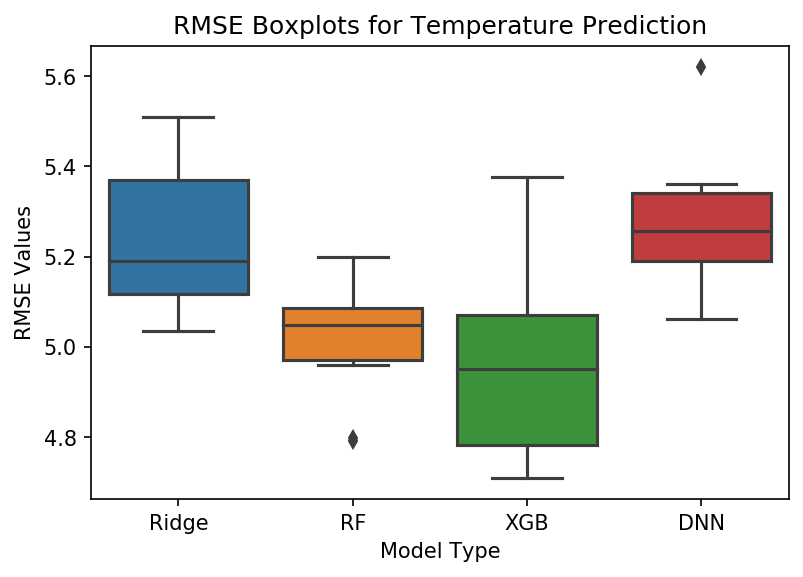

In [59]:
sns.boxplot(x="Model Type", y="RMSE Values", data=df_boxplot).set_title('RMSE Boxplots for Temperature Prediction')

Text(0.5, 1.0, 'MAE Boxplots for Temperature Prediction')

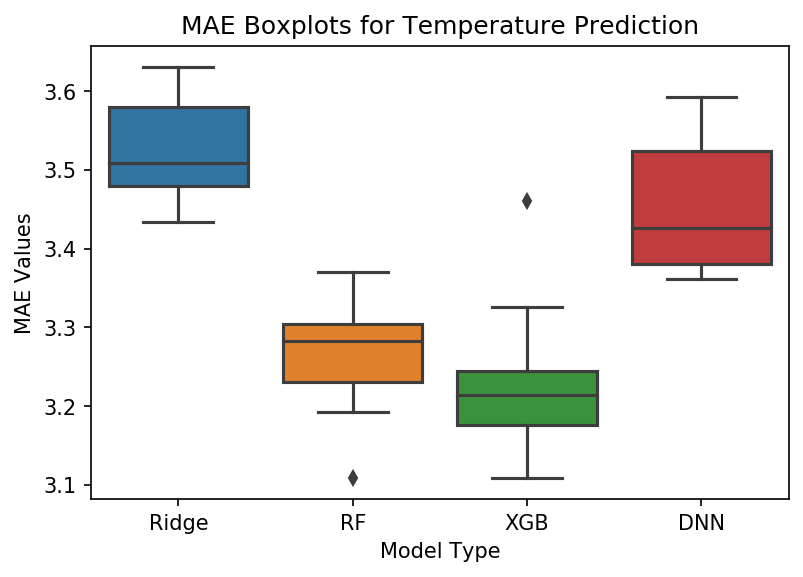

In [60]:
model_type_list = np.array([np.full((10,1),fill_value='Ridge'),
                           np.full((10,1),fill_value='RF'),
                           np.full((10,1),fill_value='XGB'),
                           np.full((10,1),fill_value='DNN')]).flatten()
model_values_list = np.concatenate((mae_ridge,
                             mae_rf,
                             mae_xgb,
                             mae3))
df_boxplot = pd.DataFrame({'Model Type':model_type_list, 'MAE Values':model_values_list})
sns.boxplot(x="Model Type", y="MAE Values", data=df_boxplot).set_title('MAE Boxplots for Temperature Prediction')

# Fetch New Well Data

In [4]:
df2 = pd.read_csv('Past+New_Wells/clean_new_well_data.csv')
num_sample=10000
sampled_df2 = df2.sample(num_sample)
sampled_df2.reset_index(inplace=True,drop=True)
sampled_df2.head()

,id,depth,temp,lat,lon,corrtemp
0,4700100668,1061.5422,26.288889,39.010401,-80.015406,31.116502
1,4709501963,1613.7636,53.566667,39.518877,-81.018447,62.533736
2,4710300645,1566.1386,43.983333,39.678222,-80.823766,50.943781
3,4709501474,378.1044,39.166389,39.374356,-80.810535,41.842262
4,4700100668,1422.1968,34.366667,39.010401,-80.015406,41.771085


In [5]:
# Interpolate Geological Layer information for X
lat_to_interpolate = sampled_df2.lat
lon_to_interpolate = sampled_df2.lon
layers = df.iloc[:,52:101].values
conds = df.iloc[:,101:150].values
mult = np.multiply(layers,conds)
np.nan_to_num(mult, 0)

f = open("optim_result.out", "r")
lines = f.readlines()

optimal_neigh = []
optimal_width = []
for line in lines:
    optimal_neigh.append(line.split(',')[0][0])
    optimal_width.append(line.split(',')[1])
optimal_neigh = np.array(optimal_neigh).astype('int')
optimal_width = np.array(optimal_width).astype('float')

# Predict 49 layers information for each sampled_df2 lat and lon
from sklearn.neighbors import KNeighborsRegressor
predicted_mults = []
for i in range(0,49):
    def gaussian_kernel(distances):
                kernel_width = optimal_width[i]
                weights = np.exp(-(distances**2)/kernel_width)
                return weights
    knn = KNeighborsRegressor(n_neighbors=optimal_neigh[i],weights=gaussian_kernel)
    #knn = KNeighborsRegressor(n_neighbors=1,weights=gaussian_kernel)
    knn.fit(np.transpose(np.array([df.LatDegree, df.LongDegree])), mult[:,i])
    y_pred = knn.predict(np.transpose(np.array([sampled_df2.lat, sampled_df2.lon])))
    predicted_mults.append(y_pred)
    
predicted_mults = np.transpose(np.array(predicted_mults))

# Predict T_SURF
def gaussian_kernel(distances):
            kernel_width = 2.598
            weights = np.exp(-(distances**2)/kernel_width)
            return weights
knn = KNeighborsRegressor(n_neighbors=1,weights=gaussian_kernel)
knn.fit(np.transpose(np.array([df.LatDegree, df.LongDegree])), df.SurfTemp)
predicted_tsurf = knn.predict(np.transpose(np.array([sampled_df2.lat, sampled_df2.lon])))

In [6]:
# Form X and Y
new_X = np.transpose(np.array([sampled_df2.lat,
                                sampled_df2.lon,
                                sampled_df2.depth,
                                predicted_tsurf]))
new_X = np.concatenate((new_X, predicted_mults),axis=1)
new_Y = sampled_df2.corrtemp.values

# CV for Ridge for New Well Data

In [7]:
def Ridgetest():
    rid = Ridge(alpha=10) # 10 is better than other params... which means not a good fit.
    rid.fit(X, Y)
    y_pred = rid.predict(scaler.transform(new_X)) # you have to scale new data
    y_test = new_Y
    std = (np.nanstd(abs(y_test-y_pred)))
    return m.mean_absolute_error(y_test, y_pred), m.mean_squared_error(y_test, y_pred), std

In [8]:
mae, mse, std = Ridgetest()
print(mae, np.sqrt(mse), std) 

14.91650900971239 337.7113253710583 10.73354947509105


# CV for RF for New Well Data

In [9]:
def Rftest():
    model = RandomForestRegressor(max_depth=10, n_estimators=50)
    model.fit(X, Y)
    y_pred = model.predict(new_X)
    y_test = new_Y
    std = (np.nanstd(abs(y_test-y_pred)))
    return m.mean_absolute_error(y_test, y_pred), m.mean_squared_error(y_test, y_pred), std

In [10]:
mae, mse, std = Rftest()
print(mae, mse, std) 

7.207742039967525 84.0820692552324 5.6683793045735005


# CV for XGBoost for New Well Data

In [11]:
import xgboost as xgb
mae_xgb = []
mse_xgb = []
std_xgb = []

gbm = xgb.XGBRegressor(learning_rate=0.01,  
                       objective='reg:squarederror', 
                       n_estimators=2000, 
                       reg_alpha=1,
                       reg_lambda=10,
                       max_depth=10, 
                       gamma=0.1)
gbm.fit(X, Y)
y_pred = gbm.predict(new_X)
y_test = new_Y
mae_xgb.append(m.mean_absolute_error(y_test, y_pred))
mse_xgb.append(m.mean_squared_error(y_test, y_pred))
std_xgb.append(np.nanstd(abs(y_test-y_pred)))

In [12]:
print(mae_xgb, mse_xgb, std_xgb)

[7.275832419671926] [88.73349353723425] [5.982955468502605]


# CV for DNN for New Well Data

In [13]:
# evaluate model
from sklearn.model_selection import train_test_split
import sklearn.metrics as m
mae3 = []
mse3 = []
std3 = []

def baseline_model():
    # create model
    # Sequential model is for just building up each layer
    model = Sequential()
    # Kernel initializer sets up the distribution for the random parameters
    model.add(Dense(50, 
                    kernel_initializer='normal', activation='relu'))
    model.add(Dense(50, 
                    kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = KerasRegressor(build_fn=baseline_model, epochs=150, batch_size=50, verbose=0)
model.fit(X, Y)
y_pred = model.predict(new_X)
y_test = new_Y
mae3.append(m.mean_absolute_error(y_test, y_pred))
mse3.append(m.mean_squared_error(y_test, y_pred))
std3.append(np.nanstd(abs(y_test-y_pred)))
print(mse3)
print(mae3)
print(std3)

[86.33507097778777]
[7.343299093703905]
[5.693068539741568]
